In [186]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import sin, cos, exp

from scipy.integrate import solve_ivp

from typing import Callable

import sim_utils
import apollo_utils

In [187]:
from numpy.random import MT19937
from numpy.random import RandomState, SeedSequence
random = RandomState(MT19937(SeedSequence(123456789)))

In [188]:
class ApolloGuidanceBankController:   
    def __init__(self, ref_data: apollo_utils.ApolloReferenceData, K: float = 1):
        """K: Over-control gain"""
        self.ref_data = ref_data
        self.K = K
        
        self.min_D_m = 0.05 * 9.81  # 0.05 Gs of Drag acceleration is the trigger
    
    @staticmethod
    def from_file(filename: str, K: float = 1):
        """Loads reference data from a file and initializes a new guidance controller"""
        ref_data = apollo_utils.ApolloReferenceData.load(filename)
        return ApolloGuidanceBankController(ref_data, K)

    def reference_bank_angle(self, t, state, params):
        """Bank angle function for open loop guidance that simply returns
           the reference bank angle"""
        v = state[2]
        if v >= 3500:
            return np.deg2rad(75);
        elif v <= 1500:
            return np.deg2rad(50);
        else:
            return np.deg2rad(50 + (75-50)*(v-1500)/(3500-1500))
    
    def closed_loop_guidance(self, t, state, params):
        h, s, v, gam = state
        
        rho0 = params['rho0']
        beta = params['beta']
        H = params['H']
        
        rho = rho0 * exp(-h/H)
        D_m = rho * v * v / (2 * beta)  # Drag Acceleration (D/m)
        
        # Compute reference bankangle
        phi = self.reference_bank_angle(t, state, params)
        
        # Wait for sensed G foroce to exceed threshold before starting
        # closed loop guidance
        if abs(D_m) < self.min_D_m and h > 60e3:
            return phi

        ref_data_row = self.ref_data.get_row_by_velocity(v)

        s_ref = ref_data_row[2]
        F1, F2, F3, D_m_ref, hdot_ref = ref_data_row[5:10]
        

        hdot = v * sin(gam)

        
        # Add correction based on Apollo guidance algorithm
        dphi = self.K * ( -(s-s_ref) - F2*(hdot-hdot_ref) + F1*(D_m - D_m_ref ))/F3

        phi = phi - dphi
        phi = abs(phi)
        phi = max(min(phi, np.pi/2), 0)
        return phi

# Monte Carlo Simulation

In [189]:
import tqdm.contrib

def monte_carlo_simulation(bank_controller, num_iter=1000):
    """Performs monte carlo simulations with pre-defined initial conditions
       and variances for given bank controller"""
    
    # Initial conditions
    h0 = 120e3; # Entry altitude
    V0 = 5500;  # Entry velocity
    gamma0_deg = -14.5; # Entry flight path angle
    s0 = 0

    # Model parameters
    params = {'H': 11.1e3,
                  'rho0': 0.020, # kg/m^3
                  'beta': 120,
                  'LD': 0.24,
                  'R_m': 3380e3,
                  'g': 3.73}

    # Terminal altitude
    h_f = 0e3

    gamma0 = np.deg2rad(gamma0_deg)

    t0 = 0
    tf = 500.
    tspan = np.linspace(t0, tf, 101)
    
    # 3-sigma variations to be simulated
    beta_3sigma = 0.05*params['beta']
    LD_3sigma = 0.08*params['LD']
    gamma_3sigma= 0.6 * np.pi/180
    
    # Generate random spreads for parameters and initial conditions
    beta_vec = random.normal(params['beta'], beta_3sigma/3, num_iter)
    LD_vec = random.normal(params['LD'], LD_3sigma/3, num_iter)
    gamma0_vec = random.normal(gamma0, gamma_3sigma/3, num_iter)

    results = []
    for i in tqdm.trange(num_iter):
        params_i = params.copy()
        params_i['beta'] = beta_vec[i]
        params_i['LD'] = LD_vec[i]
        X0 = np.array([h0, s0, V0, gamma0_vec[i]])
        
        traj_i = sim_utils.simulate_entry_trajectory(
            apollo_utils.traj_eom,
            t0, 
            tf,
            X0,
            2, # V
            600, # V_f
            params_i,
            bank_controller,
            t_eval=tspan)
        results.append(traj_i)
    
    return results


apollo = ApolloGuidanceBankController.from_file('apollo_data.npz', K=1)
np.set_printoptions(suppress=True)
# print(apollo.ref_data.X_and_lam[:,1]/1e3)

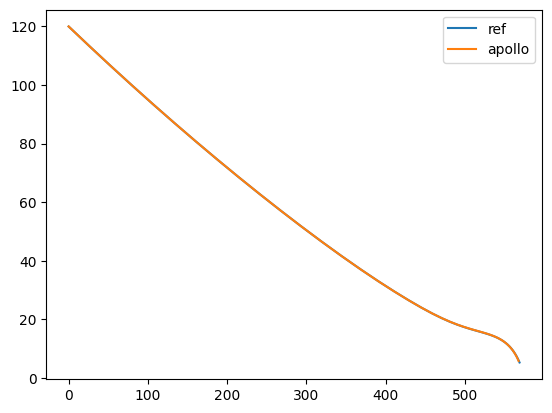

In [190]:
# Sanity check
# Initial conditions
h0 = 120e3; # Entry altitude
V0 = 5500;  # Entry velocity
gamma0_deg = -14.5; # Entry flight path angle
s0 = 0

# Model parameters
params = {'H': 11.1e3,
              'rho0': 0.020, # kg/m^3
              'beta': 120,
              'LD': 0.24,
              'R_m': 3380e3,
              'g': 3.73}

# Terminal altitude
h_f = 5e3

gamma0 = np.deg2rad(gamma0_deg)
X0 = np.array([h0, s0, V0, gamma0])
t0 = 0
tf = 500.
tspan = np.linspace(t0, tf, 101)

# print('apollo', apollo.closed_loop_guidance(0, X0, params)*180/np.pi)
# print('ref', apollo.reference_bank_angle(0, X0, params)*180/np.pi)
ref_traj = sim_utils.simulate_entry_trajectory(apollo_utils.traj_eom, t0, tf, X0, 0, h_f, params, apollo.reference_bank_angle, tspan)
ref_traj2 = sim_utils.simulate_entry_trajectory(apollo_utils.traj_eom, t0, tf, X0, 0, h_f, params, apollo.closed_loop_guidance, tspan)

# plt.plot(ref_traj.X[:,2]/1e3, np.degrees(ref_traj.u) )
# plt.plot(ref_traj2.X[:,2]/1e3, np.degrees(ref_traj2.u) )
plt.plot(ref_traj.X[:,1]/1e3, ref_traj.X[:,0]/1e3, label='ref' )
plt.plot(ref_traj2.X[:,1]/1e3, ref_traj2.X[:,0]/1e3, label='apollo' )
plt.legend()
# plt.plot(ref_traj.t, ref_traj.X[:,0]/1e3, label='ref')
# plt.plot(ref_traj2.t, ref_traj2.X[:,0]/1e3, label='ref2')
# # plt.plot(ref_traj.t, np.degrees(ref_traj.u) )
# # plt.plot(ref_traj2.t, np.degrees(ref_traj2.u) )
plt.show()

In [197]:
open_loop_results = monte_carlo_simulation(apollo.reference_bank_angle, 1000)
apollo.K = 1
closed_loop_results_K1 = monte_carlo_simulation(apollo.closed_loop_guidance, 1000)
apollo.K = 5
closed_loop_results_K5 = monte_carlo_simulation(apollo.closed_loop_guidance, 1000)

100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


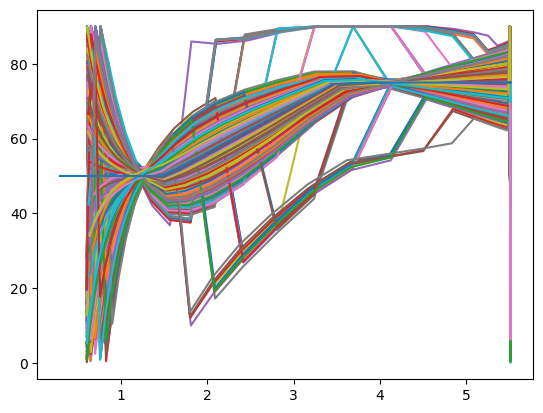

In [198]:
for res in closed_loop_results_K1:
# #     plt.plot(res.X[:,2]/1e3, res.X[:,0]/1e3)
    plt.plot(res.X[:,2]/1e3, np.degrees(res.u) )
    
# # plt.plot(apollo.ref_data.X_and_lam[:,2]/1e3, apollo.ref_data.X_and_lam[:,0]/1e3, lw=3)
plt.plot(apollo.ref_data.X_and_lam[:,2]/1e3, np.degrees(apollo.ref_data.u) )
plt.show()

In [199]:
S_closed_loop_K1 = np.array([traj.X[-1,1] for i, traj in enumerate(closed_loop_results_K1) if i != 89 and i!=90])
S_closed_loop_K5 = np.array([traj.X[-1,1] for i, traj in enumerate(closed_loop_results_K5) if i != 89 and i!=90])
S_open_loop = np.array([traj.X[-1,1] for traj in open_loop_results])

hf_closed_loop_K1 = np.array([traj.X[-1,0] for traj in closed_loop_results_K1])
hf_closed_loop_K5 = np.array([traj.X[-1,0] for traj in closed_loop_results_K5])

In [196]:
print('Open loop footprint:', abs(max(S_open_loop) - min(S_open_loop))/1e3, 'km')
print('Closed loop footprint (K=1):', abs(max(S_closed_loop_K1) - min(S_closed_loop_K1))/1e3, 'km')
print('Closed loop footprint (K=5):', abs(max(S_closed_loop_K5) - min(S_closed_loop_K5))/1e3, 'km')

Open loop footprint: 56.574564961058144 km
Closed loop footprint (K=1): 10.168117550463183 km
Closed loop footprint (K=5): 6.0443628065863155 km


In [15]:
# ipywidgets tqdm matplotlib jupyterlab numpy scipy sympy

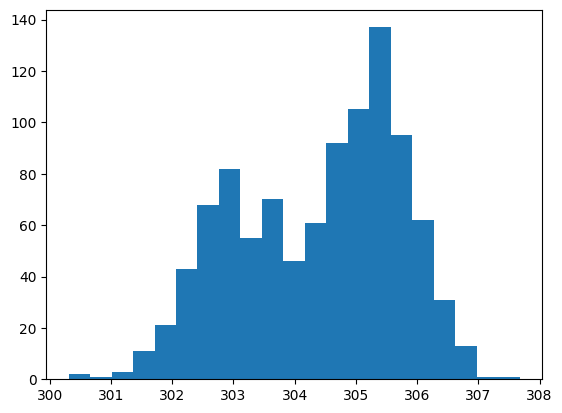

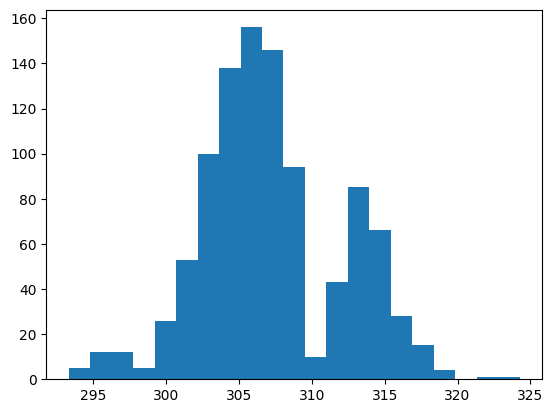

In [20]:
plt.figure()
plt.hist(S_closed_loop/1e3, 21)

plt.figure()
plt.hist(S_open_loop/1e3, 21)
plt.show()

<Figure size 640x480 with 0 Axes>

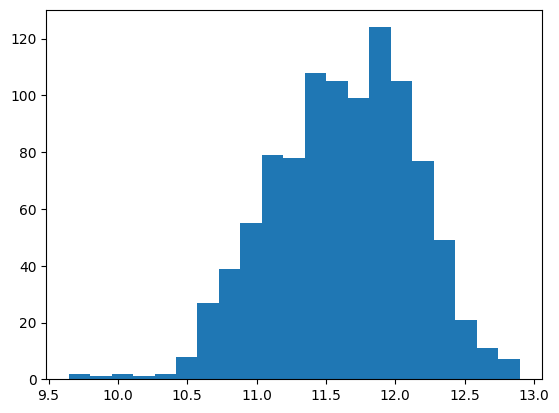

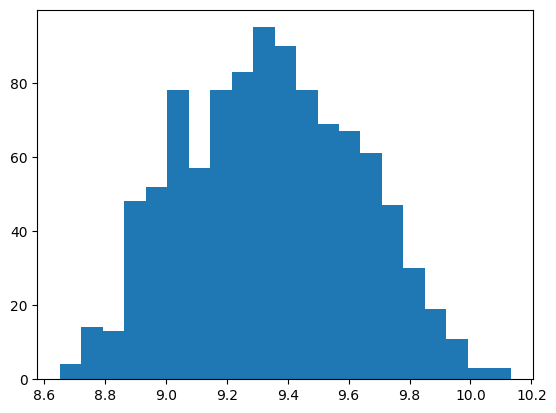

In [30]:
plt.figure()
plt.hist(hf_closed_loop_K1/1e3, 21)
plt.show()

plt.figure()
plt.hist(hf_closed_loop_K5/1e3, 21)
plt.show()

304.3839844930697 [  0.74731371 337.18396011   0.23154067  -0.00076408   0.00104357
   0.           0.           0.01344515]


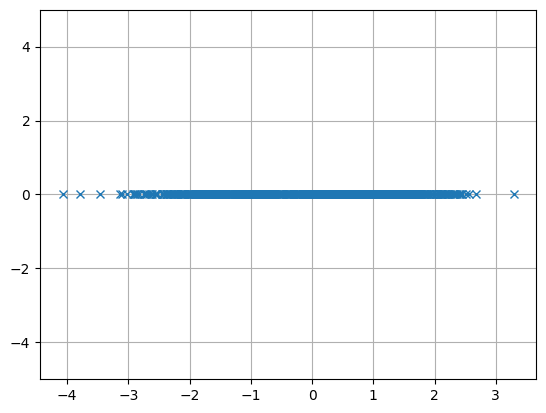

In [16]:
print(np.mean(S_closed_loop_K5/1e3), apollo.ref_data.X_and_lam[-1,:]/1e3)
plt.plot(S_closed_loop_K5/1e3 - np.mean(S_closed_loop_K5/1e3), np.zeros_like(S_closed_loop_K5), 'x')
plt.ylim([-5, 5])
plt.grid(True)
plt.show()

In [18]:
def show_footprint(S):
    mean = np.mean(S)
    sd = np.std(S)
    print('sd = ', sd)
    distance_from_mean = abs(S - mean)
    not_outlier = distance_from_mean < np.percentile(distance_from_mean, 99)
    no_outliers = S[not_outlier]
    print('Footprint:', abs(max(no_outliers) - min(no_outliers))/1e3, 'km')

show_footprint(S_closed_loop)
show_footprint(S_open_loop)

sd =  1328.8378876680144
Footprint: 5.561822929343791 km
sd =  4790.671297864449
Footprint: 23.24977394448925 km
